In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd
import matplotlib.pyplot as plt
import time

np.random.seed(1)

In [76]:
ground_truth = pd.read_csv("train.csv").as_matrix().T
data_X = ground_truth[1:] / 255
data_Y = np.eye(10)[ground_truth[:1].reshape(-1)].T

input_layer_size = data_X.shape[0]
output_layer_size = data_Y.shape[0]

print(data_X.shape, data_Y.shape)

(784, 42000) (10, 42000)


### Create placeholder (X, Y)

In [217]:
def create_placeholders(s_x, s_y):
    X = tf.placeholder(tf.float32, name = "X", shape = [s_x, None])
    Y = tf.placeholder(tf.float32, name = "Y", shape = [s_y, None])
    k = tf.placeholder(tf.float32, name = "k")
    
    return X, Y, k

tf.reset_default_graph()
print (create_placeholders(input_layer_size, output_layer_size))

(<tf.Tensor 'X:0' shape=(784, ?) dtype=float32>, <tf.Tensor 'Y:0' shape=(10, ?) dtype=float32>, <tf.Tensor 'k:0' shape=<unknown> dtype=float32>)


### Initialize parameters

In [218]:
def initialize_parameters(layer_sizes):
    tf.set_random_seed(1)
    parameters = {}

    for i in range(1, len(layer_sizes)):
        parameters["W" + str(i)] = tf.get_variable("W" + str(i), [layer_sizes[i], layer_sizes[i-1]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        parameters["b" + str(i)] = tf.get_variable("b" + str(i), [layer_sizes[i], 1], initializer = tf.zeros_initializer())
        
    return parameters
    
tf.reset_default_graph()
print(initialize_parameters([input_layer_size, 30, output_layer_size])) #2400, 1400, 800



{'W1': <tf.Variable 'W1:0' shape=(30, 784) dtype=float32_ref>, 'b1': <tf.Variable 'b1:0' shape=(30, 1) dtype=float32_ref>, 'W2': <tf.Variable 'W2:0' shape=(10, 30) dtype=float32_ref>, 'b2': <tf.Variable 'b2:0' shape=(10, 1) dtype=float32_ref>}


In [219]:
def forward_propagation(X, parameters, k):
    L = len(parameters) // 2
    A = X
    for i in range(L):
        W = parameters["W" + str(i + 1)]
        if i < L-1:
            W = tf.nn.dropout(W, k)
        b = parameters["b" + str(i + 1)]
        Z = tf.add(tf.matmul(W, A), b)
        if i < L-1:
            A = tf.nn.relu(Z)
        else:
            A = Z
    return A

In [220]:
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y, k = create_placeholders(input_layer_size, output_layer_size)
    parameters = initialize_parameters([input_layer_size, 30, output_layer_size])
    ZL = forward_propagation(X, parameters, k)
    print("ZL = " + str(ZL))

ZL = Tensor("Add_1:0", shape=(10, ?), dtype=float32)


In [221]:
def compute_cost(ZL, Y,):
    L = len(parameters) // 2
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost

In [222]:
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y, k = create_placeholders(input_layer_size, output_layer_size)
    parameters = initialize_parameters([input_layer_size, 30, output_layer_size])
    ZL = forward_propagation(X, parameters, k)
    cost = compute_cost(ZL, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


## Model

In [235]:
def model(num_epochs = 300):
    ops.reset_default_graph() 
    tf.set_random_seed(1)
    seed = 3
    
    #hyper parameters
    learning_rate = 0.0001
    minibatch_size = 64
    keep_probs = 0.3
    
    costs = []
    accuracies_train = []
    accuracies_test = []
    
    # params
    X, Y, k = create_placeholders(input_layer_size, output_layer_size)
    parameters = initialize_parameters([input_layer_size, 1000, 1000, 784, 128, output_layer_size])
    #forward prop
    ZL = forward_propagation(X, parameters, k)
    #cost
    cost = compute_cost(ZL, Y)
    #optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    data_X_train = data_X[:, :29400]
    data_Y_train = data_Y[:, :29400]
    data_X_test = data_X[:, 29400:]
    data_Y_test = data_Y[:, 29400:]
    
    minibatch_count = (data_Y_train.shape[1] // minibatch_size) + 1
    
    #define accuracy fn
    correct_prediction = tf.equal(tf.argmax(ZL), tf.argmax(Y))        
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    #prediction
    prediction = tf.argmax(ZL)
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            epoch_cost = 0. 
            for i in range(minibatch_count):
                data_X_minibatch = data_X_train[:, i*minibatch_size:(i+1)*minibatch_size]
                data_Y_minibatch = data_Y_train[:, i*minibatch_size:(i+1)*minibatch_size]
            
                # compute cost
                _ , batch_cost = sess.run([optimizer, cost], feed_dict={X: data_X_minibatch, Y: data_Y_minibatch, k: keep_probs})
                epoch_cost += batch_cost / minibatch_count
            
            costs.append(epoch_cost)
            if epoch % 4 == 0:
                train_accuracy = accuracy.eval({X: data_X_train, Y: data_Y_train, k: 1})
                test_accuracy = accuracy.eval({X: data_X_test, Y: data_Y_test, k: 1})
                accuracies_train.append(train_accuracy)
                accuracies_test.append(test_accuracy)
                
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                print ("Accuracies after epoch %i: train %f - test %f" % (epoch, train_accuracy, test_accuracy))
                
        print ("Train Accuracy:", accuracy.eval({X: data_X_train, Y: data_Y_train, k: 1}))
        print ("Test Accuracy:", accuracy.eval({X: data_X_test, Y: data_Y_test, k: 1}))
        
        # compute prediction
        compo_data = pd.read_csv("test.csv").as_matrix().T
        X_compo = compo_data / 255
        print("X_compo:", X_compo.shape)
        submissions = prediction.eval({X: X_compo, k: 1})
        df = pd.DataFrame(submissions.T, columns=['Label'])
        df.index += 1
        df.to_csv('submission.csv', index=True, index_label='ImageId')

        print("Prediction saved!")
           
        # plot costs and accuracies
        plt.figure()
        plt.plot(costs)  # plott cost fn
        plt.legend(['cost'])
        
        plt.figure()
        plt.plot(accuracies_train)  # plott accuracy fn
        plt.plot(accuracies_test)  # plott accuracy fn
        plt.legend(['accuracy train', 'accuracy test'])

        plt.show()

Cost after epoch 0: 2.539790
Accuracies after epoch 0: train 0.531599 - test 0.531270
Cost after epoch 4: 0.915142
Accuracies after epoch 4: train 0.769150 - test 0.768809
Cost after epoch 8: 0.519864
Accuracies after epoch 8: train 0.893265 - test 0.891429
Cost after epoch 12: 0.375161
Accuracies after epoch 12: train 0.926565 - test 0.924603
Cost after epoch 16: 0.291470
Accuracies after epoch 16: train 0.942721 - test 0.939524
Cost after epoch 20: 0.232099
Accuracies after epoch 20: train 0.954184 - test 0.950079
Cost after epoch 24: 0.196212
Accuracies after epoch 24: train 0.962891 - test 0.956349
Cost after epoch 28: 0.172644
Accuracies after epoch 28: train 0.969524 - test 0.962857
Cost after epoch 32: 0.148001
Accuracies after epoch 32: train 0.974388 - test 0.965238
Cost after epoch 36: 0.135288
Accuracies after epoch 36: train 0.977245 - test 0.967937
Cost after epoch 40: 0.124244
Accuracies after epoch 40: train 0.980102 - test 0.969206
Cost after epoch 44: 0.110219
Accuraci

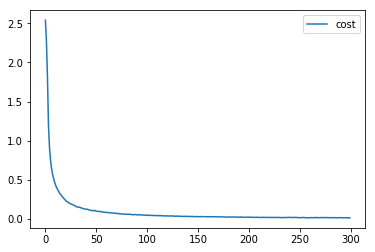

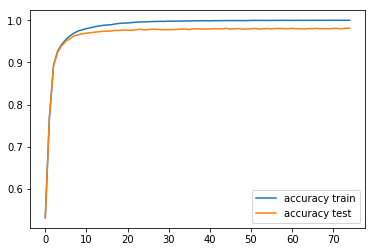

In [236]:
model()